In [1]:
import numpy as np
import matplotlib.pyplot as plt

import RDL_seminar5_src as src

##### Example GridWorld
In the cell below we create an instance of GridWorld. The `default` GridWorld is the example of p. 165 of Sutton & Barto. If you set `default=False`, a random gridworld is generated.

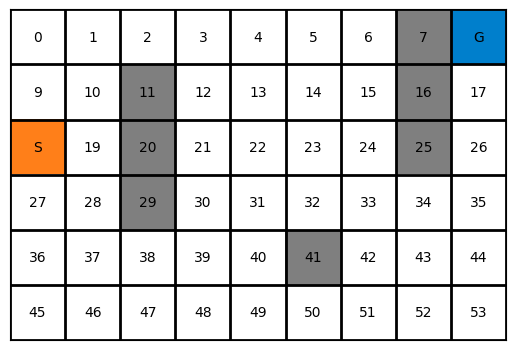

In [2]:
gridworld = src.GridWorld(default=True)
src.print_grid(gridworld, print_states=True)

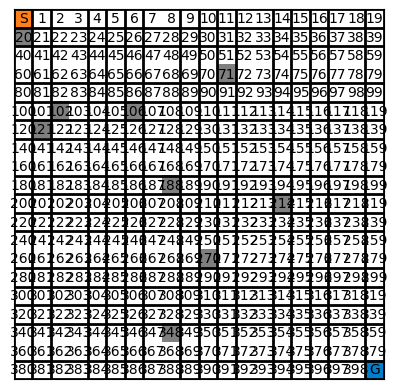

In [3]:
gridworld = src.GridWorld(default=False, grid_size = (20, 20), seed = 42)
gridworld.initial_state = 0                  # Top-left corner (row 0, col 0)
gridworld.terminal_state = gridworld.nstates - 1  # Bottom-right corner (row 19, col 19)
src.print_grid(gridworld, print_states=True)

In [4]:
s = np.random.choice(gridworld.state_space) # draw random state
a = np.random.choice(gridworld.actions) # draw random action

s_prime, r = gridworld.interact(s, a) # interact with the environment
print(s, a, s_prime, r)

372 R 373 0.0


### Policies
In the cells below, we randomly generate policies (both deterministic and probabilistic) and we display them.

The shape of a policy:  (400, 4)


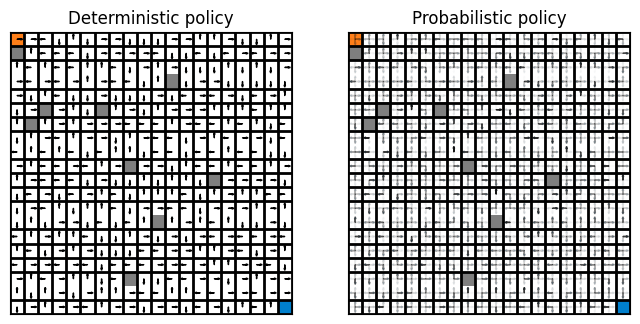

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
policy1 = src.generate_random_policy(gridworld, deterministic=True)
policy2 = src.generate_random_policy(gridworld, deterministic=False)

ax = axes[0]
src.print_grid(gridworld, ax=ax)
src.print_policy(policy1, gridworld, ax=ax)
ax.set_title("Deterministic policy");

ax = axes[1]
src.print_grid(gridworld, ax=ax)
src.print_policy(policy2, gridworld, ax=ax)
ax.set_title("Probabilistic policy")

print("The shape of a policy: ", policy1.shape)

### Overview
In the cell below we plot three versions of gridworld. The left version shows the states. The middle version shows a state-value function. The rightmost version shows a policy.

Warning: in this example the state value function and policy are related via a randomly generated action-value function.

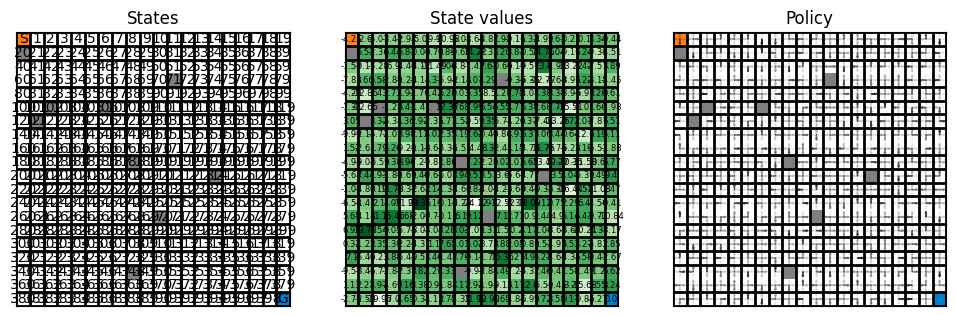

In [6]:
policy = src.generate_random_policy(gridworld, deterministic=False) # randomly generate stochastic policy
Q = src.initialize_Q(gridworld, random=True) # randomly generate action-value function
V = src.compute_V(policy, Q) # compute state-value function

src.print_overview(gridworld, V, policy)

### Dyna-Q

Implementation of the Dyna-Q algorithm of p. 164 of Sutton & Barto.

In [7]:
import random

def update_Q(gridworld, Q, s, a, s_prime, r, alpha=0.1, gamma=0.95):

    a_idx = gridworld.actions_to_idx[a]

    return Q[s, a_idx] + alpha * (r + gamma * np.max(Q[s_prime]) - Q[s, a_idx])

def greedy_policy(gridworld, Q):

    policy = np.zeros_like(Q)
    states_, actions_ = np.nonzero((Q.T == np.max(Q, axis=1)).T)
    for s in np.arange(gridworld.nstates):

                policy[s, np.random.choice(actions_[states_ == s])] = 1.0
                
    return policy

def train(gridworld, episodes=10, n=0, alpha=0.1, gamma=0.95, epsilon=0.1):

    model = {}
    Q = src.initialize_Q(gridworld, random=False)
    steps_history = np.array([], dtype=int)

    for i in range(episodes):

        s = gridworld.initial_state
        steps = 0
        while not s == gridworld.terminal_state:

            steps += 1

            # epsilon-greedy action selection
            if epsilon < np.random.rand(): # greedy
                a_idx = np.random.choice(np.nonzero(Q[s] == np.max(Q[s]))[0])
            else: # random
                a_idx = np.random.randint(4)
            a = gridworld.actions[a_idx]

            # interaction with environment
            s_prime, r = gridworld.interact(s, a)

            # update Q
            Q[s, a_idx] = update_Q(gridworld, Q, s, a, s_prime, r, alpha=alpha, gamma=gamma)

            # store interaction
            model[(s, a)] = (s_prime, r)

            # planning

            for t in range(n):

                random_s, random_a = random.choice(list(model.keys()))

                s_prime_plan, r_plan = model[(random_s, random_a)]

                random_a_idx = gridworld.actions_to_idx[random_a]

                Q[random_s, random_a_idx] = update_Q(gridworld, Q, random_s, random_a, s_prime_plan, r_plan, alpha=alpha, gamma=gamma)

            # update state to next state
            s = s_prime
        
        steps_history = np.append(steps_history, steps)
    
    return Q, steps_history, greedy_policy(gridworld, Q)

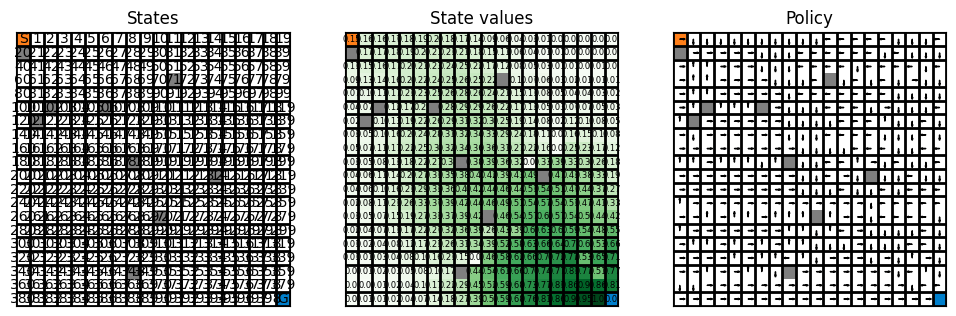

In [8]:
Q, steps_history, policy = train(gridworld, n=5, episodes=500)
V = src.compute_V(policy, Q)

src.print_overview(gridworld, V, policy)

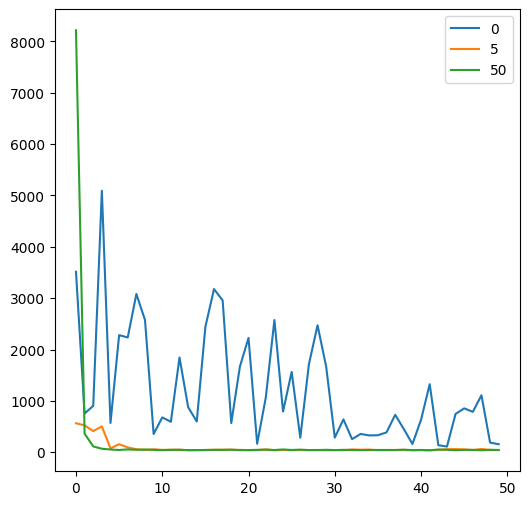

In [9]:
episodes = 50
ns = [0, 5, 50]
n_ns = len(ns)
steps_histories = np.zeros((n_ns, episodes))

for i, n in enumerate(ns):
    _, steps_history, _ = train(gridworld, n=n, episodes=50)
    steps_histories[i] = steps_history

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

axes.plot(steps_histories.T)
axes.legend(ns);

In [16]:
### new version Prioritized Sweeping

import random
import heapq
import numpy as np
from collections import defaultdict
from queue import PriorityQueue

def update_Q(gridworld, Q, s, a, s_prime, r, alpha=0.1, gamma=0.95):
    a_idx = gridworld.actions_to_idx[a]
    return Q[s, a_idx] + alpha * (r + gamma * np.max(Q[s_prime]) - Q[s, a_idx])

def greedy_policy(gridworld, Q):
    policy = np.zeros_like(Q)
    states_, actions_ = np.nonzero((Q.T == np.max(Q, axis=1)).T)
    for s in np.arange(gridworld.nstates):
        policy[s, np.random.choice(actions_[states_ == s])] = 1.0
    return policy

def train_prioritized_sweeping(gridworld, episodes=10, n=5, alpha=0.1, gamma=0.95, epsilon=0.1, theta=1e-5):

    Q = src.initialize_Q(gridworld, random=False)
    model = {}
    steps_history = np.array([], dtype=int)
    priority_queue = PriorityQueue()
    predecessors = {}
    
    for ep in range(episodes):

        s = gridworld.initial_state
        steps = 0

        while not s == gridworld.terminal_state:

            steps += 1

            # Epsilon-greedy action selection
            if epsilon < np.random.rand():  # greedy
                a_idx = np.random.choice(np.nonzero(Q[s] == np.max(Q[s]))[0])
            else:  # random
                a_idx = np.random.randint(len(gridworld.actions))
            a = gridworld.actions[a_idx]

            # Environment interaction
            s_prime, r = gridworld.interact(s, a)

            # Update Interaction with Environment

            Q[s, a_idx] = update_Q(gridworld, Q, s, a, s_prime, r,  alpha=alpha, gamma=gamma)

            # Store model
            model[(s, a)] = (s_prime, r)

            # Store predecessor
            if s_prime not in predecessors:
                predecessors[s_prime] = [(s, a)]
            else:
                predecessors[s_prime].append((s, a))

            # Compute priority
            P = abs(r + gamma * np.max(Q[s_prime]) - Q[s, a_idx])
            if P > theta:
                priority_queue.put((-P, s, a))

            # Planning
            for _ in range(n):
                if priority_queue.empty():
                    break
                
                _, s_pl, a_pl = priority_queue.get()
                s_prime_pl, r_pl = model[(s_pl, a_pl)]
                a_pl_idx = gridworld.actions_to_idx[a_pl]
                Q[s_pl, a_pl_idx] = update_Q(gridworld, Q, s_pl, a_pl, s_prime_pl, r_pl, alpha=alpha, gamma=gamma)

                # Update predecessors
                for s_pred, a_pred in predecessors.get(s_pl, []):
                    _, r_pred = model[(s_pred, a_pred)]
                    a_pred_idx = gridworld.actions_to_idx[a_pred]
                    P_pred = abs(r_pred + gamma * np.max(Q[s_pl]) - Q[s_pred, a_pred_idx])
                    if P_pred > theta:
                        priority_queue.put((-P_pred, s_pred, a_pred))

            # Move to next state
            s = s_prime

        steps_history = np.append(steps_history, steps)

    return Q, steps_history, greedy_policy(gridworld, Q)

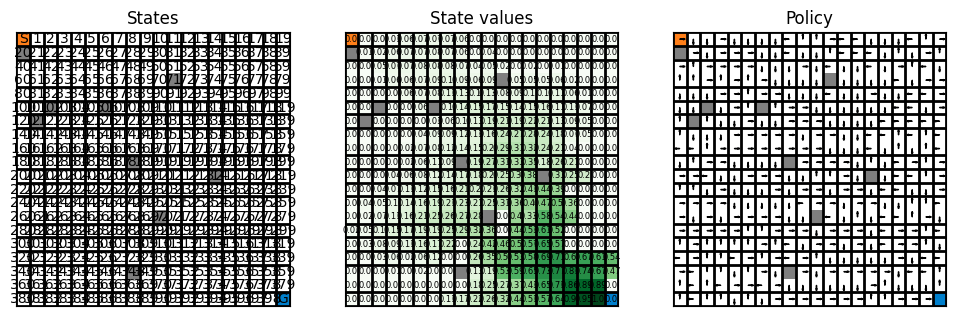

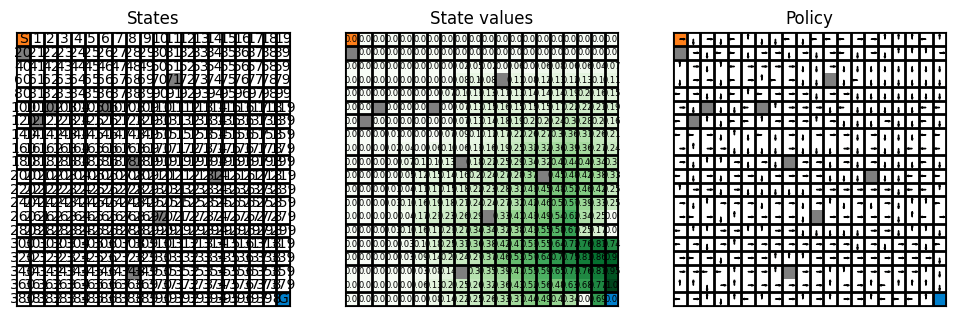

In [26]:
# Sweep Train
Q_sweep, steps_history_sweep, policy_sweep = train_prioritized_sweeping(gridworld, n=5, episodes=100)
V_sweep = src.compute_V(policy_sweep, Q_sweep)

# Dyna-Q Train
Q_dynaq, steps_history_dynaq, policy_dynaq = train_prioritized_sweeping(gridworld, n=5, episodes=100)
V_dynaq = src.compute_V(policy_dynaq, Q_dynaq)


src.print_overview(gridworld, V_sweep, policy_sweep)
src.print_overview(gridworld, V_dynaq, policy_dynaq)

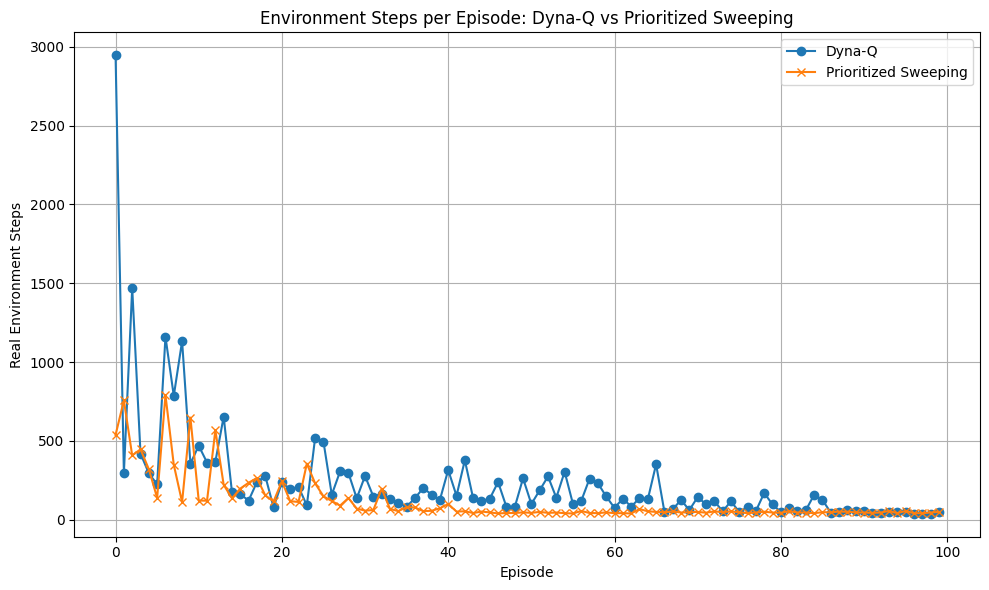

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(steps_history_dynaq, label="Dyna-Q", marker='o')
plt.plot(steps_history_sweep, label="Prioritized Sweeping", marker='x')
plt.xlabel("Episode")
plt.ylabel("Real Environment Steps")
plt.title("Environment Steps per Episode: Dyna-Q vs Prioritized Sweeping")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

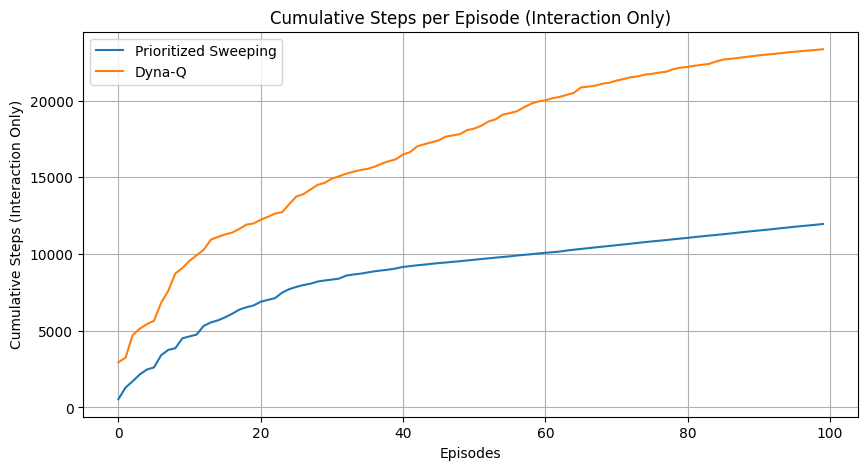

In [28]:
# step history sweep, dynaq are two lists of steps per episode , make a cumulative sum plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(steps_history_sweep), label="Prioritized Sweeping")
plt.plot(np.cumsum(steps_history_dynaq), label="Dyna-Q")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Steps (Interaction Only)")
plt.title("Cumulative Steps per Episode (Interaction Only)")
plt.legend()
plt.grid()
plt.show()

## Second Part

Using device: mps
Episode 1/1000
Episode 2/1000
Episode 3/1000
Episode 4/1000
Episode 5/1000
Episode 6/1000
Episode 7/1000
Episode 8/1000


/var/folders/n9/6pwt6r5x7cl54yr_vrdyfr_w0000gn/T/ipykernel_61762/3935496208.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state_batch = torch.FloatTensor(state_batch)


Episode 9/1000
Episode 10/1000
Episode 11/1000
Episode 12/1000
Episode 13/1000
Episode 14/1000
Episode 15/1000
Episode 16/1000
Episode 17/1000
Episode 18/1000
Episode 19/1000
Episode 20/1000
Episode 21/1000
Episode 22/1000
Episode 23/1000
Episode 24/1000
Episode 25/1000
Episode 26/1000
Episode 27/1000
Episode 28/1000
Episode 29/1000
Episode 30/1000
Episode 31/1000
Episode 32/1000
Episode 33/1000
Episode 34/1000
Episode 35/1000
Episode 36/1000
Episode 37/1000
Episode 38/1000
Episode 39/1000
Episode 40/1000
Episode 41/1000
Episode 42/1000
Episode 43/1000
Episode 44/1000
Episode 45/1000
Episode 46/1000
Episode 47/1000
Episode 48/1000
Episode 49/1000
Episode 50/1000
Episode 51/1000
Episode 52/1000
Episode 53/1000
Episode 54/1000
Episode 55/1000
Episode 56/1000
Episode 57/1000
Episode 58/1000
Episode 59/1000
Episode 60/1000
Episode 61/1000
Episode 62/1000
Episode 63/1000
Episode 64/1000
Episode 65/1000
Episode 66/1000
Episode 67/1000
Episode 68/1000
Episode 69/1000
Episode 70/1000
Episode 7

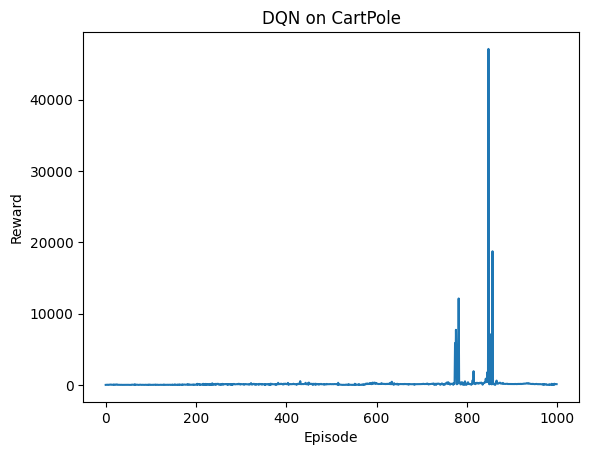

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Create the CartPole environment
env = gym.make("CartPole-v1")

# Torch device configuration mps
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)

# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 1000

# Initialize Q-networks
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  # Exploit
    
# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch)

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main training loop
rewards_per_episode = []
steps_done = 0


for episode in range(episodes):
    print(f"Episode {episode + 1}/{episodes}")
    state,_ = env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        # Select action
        action = select_action(state, epsilon)
        next_state, reward, done, _ ,_ = env.step(action)

        memory.append((state, action, reward, next_state, done))
        
        # Update state
        state = next_state
        episode_reward += reward
        
        # Optimize model
        optimize_model()

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        steps_done += 1

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    
    rewards_per_episode.append(episode_reward)

# Plotting the rewards per episode
import matplotlib.pyplot as plt
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN on CartPole')
plt.show()